In [5]:
import os
import pandas as pd
import calendar
import time
import csv
import datatable as dt
import numpy as np
import math
import fileutils
import time
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [6]:
def gridinfo():
    rdiff=2227
    minnorth=333237
    #maxwest=1160624
    minwest=1156167
    maxeast=2747676
    maxsouth=3504175
    gridwidth=((maxeast-minwest) % rdiff) + 1
    firstid = minwest-math.ceil((minwest-minnorth) / rdiff)*rdiff
    gridheight=math.ceil((maxsouth-firstid) / rdiff)

    return rdiff, firstid, gridwidth, gridheight

In [7]:
def get_grid_xy(_id, firstid, rdiff):
    row = int((_id-firstid)/rdiff)
    col = _id-firstid-rdiff*row
    return row,col

In [8]:
def fill_grid_from_dict(ggrid, firstid, iddict, rdiff, field="id"):
    cnt=0
    #print("Filling grid %s..."%field)
    for _id in iddict:
        try:
            row,col = get_grid_xy(_id, firstid, rdiff)
            if field=="id":
                ggrid[row,col]=_id
            elif field=="array":
                ggrid[row,col]=iddict[_id]
            #cnt+=1
            #if cnt % 50000 == 0: print(cnt)
        except:
            print('dict: %s'%iddict[_id])
            continue
    return ggrid

In [9]:
def loaddaydict(fday, exfeat):
    print("Loading %s..."%fday)
    featcolumns=getfeatcolumns(fday, exfeat)
    daydict={}
    with open(fday, 'r') as featfile:
        cnt=0
        #if not checksequence(fday, exfeat): return {}
        for dictline in csv.DictReader(featfile):
            id_int = int(float(dictline["id"]))
            for k in exfeat:
                if k in dictline:
                    del dictline[k]
            featvals=list(dictline.values())
            daydict[id_int]=np.array(featvals)
    return daydict,featcolumns

In [10]:
def printduration(start, mess=''):
    duration = time.time() - start
    start = time.time()
    print("Duration %s %.1f" % (mess,duration))
    return start

In [11]:
def creategrid(fday, exfeat):
    rdiff, firstid, gridwidth, gridheight = gridinfo()
    start = time.time()
    daydict, featcolumns = loaddaydict(fday, exfeat)
    featn=len(featcolumns)
    start = printduration(start, "of loading day:")
    ggrid_id = np.zeros((gridwidth, gridheight))
    ggrid_patchpool = np.zeros((gridheight, gridwidth, featn))
    fill_grid_from_dict(ggrid_id, firstid, daydict,rdiff)
    start = printduration(start, "of filling grid ids:")
    fill_grid_from_dict(ggrid_patchpool, firstid, daydict, rdiff, "array")
    start = printduration(start, "of filling grid features:")
    return ggrid_id, ggrid_patchpool

In [12]:
def createpatches(fday, exfeat, patchwidth=64, padding=0):
    ggrid_id, ggrid_patchpool = creategrid(fday, exfeat)
    rdiff, firstid, gridwidth, gridheight = gridinfo()
    pw=patchwidth
    patchlist=[]
    #print(np.count_nonzero(ggrid_patchpool))
    for w in range(0, gridwidth, pw):
        for h in range(0, gridheight, pw):
            patch=ggrid_patchpool[h:h+pw,w:w+pw,:]
            if np.count_nonzero(patch)>0:
                pass
            if np.count_nonzero(ggrid_patchpool[h:h+pw,w:w+pw,:])>0:
                pass
            patchlist.append(patch)
    start = printduration(start, "of patch creation:")
    return patchlist

In [13]:
def walkmonthdays():
    sfolder = '/data2/ffp/datasets/daily/2015/08'
    exfeat = ["id", "firedate"]
    for fday in fileutils.find_files(sfolder, '*_norm.csv', listtype="walk"):
        print(fday)
        #patchlist=createpatches(fday, exfeat)
        ggrid_id, ggrid_patchpool = creategrid(fday, exfeat)
        if np.count_nonzero(ggrid_patchpool[:,:,17])>0:
            print("day contains fire!!")
            break
        else:
            print("no fire in day")
    return ggrid_id, ggrid_patchpool

In [14]:
def walkmonthdays2():
    sfolder = '/data2/ffp/datasets/daily/2021/08'
    exfeat = ["","id", "firedate"]
    fday='/data2/ffp/datasets/daily/2021/08/20210801_norm.csv'
    featcolumns = getfeatcolumns(fday, exfeat)
    featn = len(featcolumns)
    rdiff, firstid, gridwidth, gridheight = gridinfo()
    monthgrid = np.zeros((gridheight, gridwidth, featn*31), dtype=np.float16)
    i=0
    for fday in fileutils.find_files(sfolder, '*_norm.csv', listtype="walk"):
        dayf = os.path.basename(fday)
        print(dayf)
        #patchlist=createpatches(fday, exfeat)
        ggrid_id, ggrid_patchpool = creategrid(fday, exfeat)
        dint = int(dayf[6:8])-1
        monthgrid[:,:,dint*featn:(dint+1)*featn] = ggrid_patchpool.copy()
        if i==3: break
        i+=1
    return monthgrid

In [15]:
def getfeatcolumns(fday, exfeat):
    with open(fday) as f:
        reader = csv.reader(f)
        for featcolumns in reader:
            break
    for k in exfeat:
        if k in featcolumns:
            featcolumns.remove(k)
    featdict={k:featcolumns.index(k) for k in featcolumns }
    return featdict

In [16]:
def plotfeatture(feat, featdict, ggrid, cmap='Spectral'):
    gfeat=ggrid[:,:,featdict[feat]]
    gfeat[gfeat<0] = 0
    gfeat[gfeat>1] = 1
    ax = sns.heatmap(gfeat, cmap=cmap)
    plt.show()

In [17]:
def plotfeatures(n, m, start, ggrid, filt=[]):
    sbplt=(n,m)
    f, ax= plt.subplots(sbplt[0],sbplt[1], figsize=(m*4,n*3), sharey=True, sharex=True)
    cnt=0
    g={}
    for feat in sorted(featdict):
        if any(flt in feat for flt in filt): continue
        cnt+=1
        if cnt<start: continue
        xplt=(cnt-start)%sbplt[1]
        yplt=(cnt-start)//sbplt[1]
        if n>1:
            pltax=ax[yplt,xplt]
        else:
            pltax=ax[cnt-start]
        ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
        print('Plotting %s feature : %s at subplot %d,%d'%(ordinal(featdict[feat]),feat,yplt,xplt))
        gfeat=ggrid[:,:,featdict[feat]].copy()
        l0 = gfeat[gfeat<0].size
        g1 = gfeat[gfeat>1].size
        if l0>0 or g1>0:
            print('Warning! %d values <0 and %d values >1 for feature %d:%s. Replacing with limit...'%(l0,g1,cnt,feat))
            gfeat[gfeat<0] = 0
            gfeat[gfeat>1] = 1
        g[cnt] = sns.heatmap(gfeat, cmap='Spectral_r', ax=pltax)
        g[cnt].set_title(feat)
        if cnt-start+1==n*m: break
    plt.show()

In [18]:
def featurestat(ggrid):
    featdict = getfeatcolumns(fday, exfeat)
    stats=[]
    for feat in sorted(featdict):
        gfeat=ggrid[:,:,featdict[feat]]
        l0 = gfeat[gfeat<0].size
        g1 = gfeat[gfeat>1].size
        if l0>0 or g1>0:
            print('Warning! %d values <0 and %d values >1 for feature %d:%s'%(l0,g1,cnt,feat))
        stats+=[{'feature':feat, 'min':gfeat.min(), 'max':gfeat.max(), 'mean': gfeat.mean(), 'std': gfeat.std()}]
    statspd=pd.DataFrame(stats)
    return statspd


In [19]:
#daydict,featcolumns = loaddaydict(fday, exfeat)
#fday='/data2/ffp/datasets/daily/2015/09/20150911_norm.csv'
#fday='/data2/ffp/datasets/daily/2015/08/20150818_norm.csv'
fday='/data2/ffp/datasets/daily/2020/07/20200723_norm.csv'
#fday='/data2/ffp/datasets/daily/2021/08/20210810_norm.csv'
exfeat = ["","id", "firedate"]

In [20]:
featdict = getfeatcolumns(fday, exfeat)

In [21]:
ggrid_patchpool[ggrid_patchpool>0].size

NameError: name 'ggrid_patchpool' is not defined

In [22]:
mgrig = walkmonthdays2()

20210813_norm.csv
Loading /data2/ffp/datasets/daily/2021/08/20210813_norm.csv...
Duration of loading day: 19.8
Duration of filling grid ids: 0.2
Duration of filling grid features: 13.3
20210818_norm.csv
Loading /data2/ffp/datasets/daily/2021/08/20210818_norm.csv...
Duration of loading day: 16.8
Duration of filling grid ids: 0.2
Duration of filling grid features: 13.3


KeyboardInterrupt: 

In [19]:
mg = mgrig[:, :, 91:182]
mg[mg>0].size

0

In [34]:
#walkmonthdays()
ggrid_id, ggrid_patchpool = creategrid(fday, exfeat)

Loading /data2/ffp/datasets/daily/2020/07/20200723_norm.csv...
Duration of loading day: 20.3
Duration of filling grid ids: 0.3
Duration of filling grid features: 18.2


In [23]:
stats = featurestat(ggrid_patchpool)

NameError: name 'ggrid_patchpool' is not defined

In [36]:
stats1=stats[(~stats['feature'].str.contains('corine')) & (~stats['feature'].str.contains('dir_max')) & (~stats['feature'].str.contains('dom_dir'))]
stats1[(~stats1['feature'].str.contains('wkd')) & (~stats1['feature'].str.contains('month'))]

,feature,min,max,mean,std
0,aspect,0.0,1.000000,0.088610,0.221817
41,curvature,0.0,1.000000,0.093510,0.198974
42,dem,0.0,1.000000,0.035994,0.100875
59,dom_vel,0.0,0.688578,0.036445,0.096933
60,evi,0.0,0.854852,0.086337,0.187989
61,f81,0.0,1.000000,0.026794,0.095542
62,fire,0.0,1.000000,0.000004,0.001980
63,frequency,0.0,1.000000,0.005133,0.042665
64,lst_day,0.0,0.749450,0.106297,0.225687
65,lst_night,0.0,0.665195,0.099100,0.210329


Plotting 6th feature : dem at subplot 0,0
Plotting 4th feature : dom_vel at subplot 0,1
Plotting 11th feature : evi at subplot 0,2
Plotting 88th feature : f81 at subplot 0,3
Plotting 87th feature : frequency at subplot 1,0
Plotting 12th feature : lst_day at subplot 1,1
Plotting 13th feature : lst_night at subplot 1,2
Plotting 14th feature : max_dew_temp at subplot 1,3
Plotting 0th feature : max_temp at subplot 2,0
Plotting 15th feature : mean_dew_temp at subplot 2,1
Plotting 2nd feature : mean_temp at subplot 2,2
Plotting 16th feature : min_dew_temp at subplot 2,3
Plotting 1st feature : min_temp at subplot 3,0
Plotting 10th feature : ndvi_new at subplot 3,1
Plotting 5th feature : rain_7days at subplot 3,2
Plotting 7th feature : slope at subplot 3,3


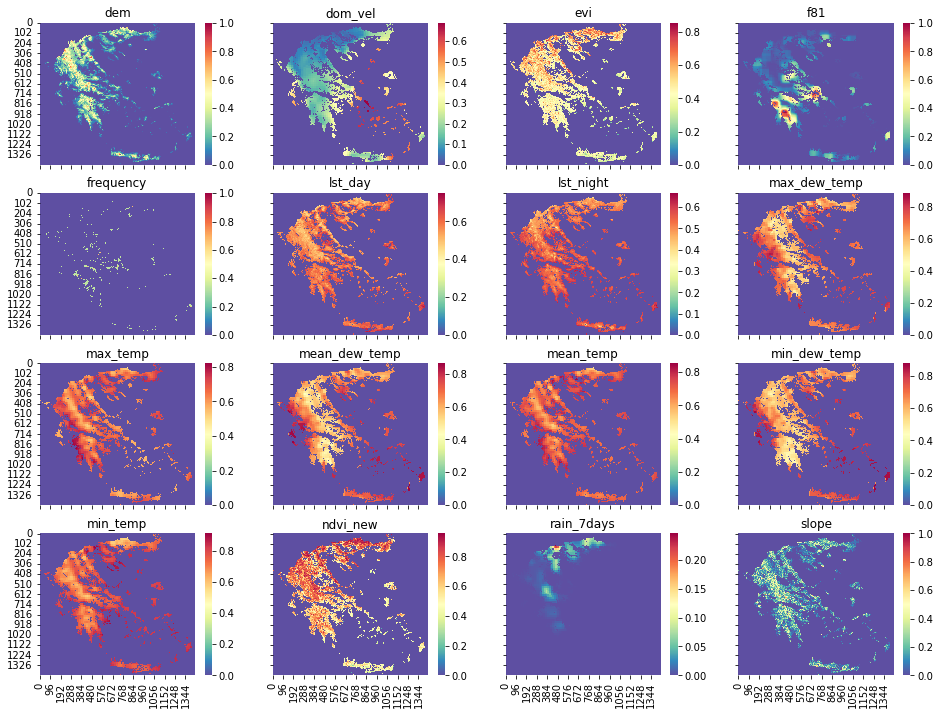

In [37]:
plotfeatures(4, 4, 1, ggrid_patchpool, ['corine', 'dom_dir', 'dir_max', 'wkd', 'month', 'res_max', 'fire', 'aspect', 'curvature'])

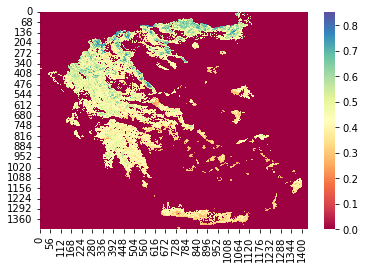

In [133]:
plotfeatture("evi", featdict, ggrid_patchpool)#, cmap='Spectral_r')

Plotting 9th feature : aspect at subplot 0,0
Plotting 34th feature : corine_111 at subplot 0,1
Plotting 35th feature : corine_112 at subplot 0,2
Plotting 36th feature : corine_121 at subplot 0,3
Plotting 37th feature : corine_122 at subplot 1,0
Plotting 38th feature : corine_123 at subplot 1,1
Plotting 39th feature : corine_124 at subplot 1,2
Plotting 40th feature : corine_131 at subplot 1,3
Plotting 41st feature : corine_132 at subplot 2,0
Plotting 42nd feature : corine_133 at subplot 2,1
Plotting 43rd feature : corine_141 at subplot 2,2
Plotting 44th feature : corine_142 at subplot 2,3
Plotting 45th feature : corine_211 at subplot 3,0
Plotting 46th feature : corine_212 at subplot 3,1
Plotting 47th feature : corine_213 at subplot 3,2
Plotting 48th feature : corine_221 at subplot 3,3


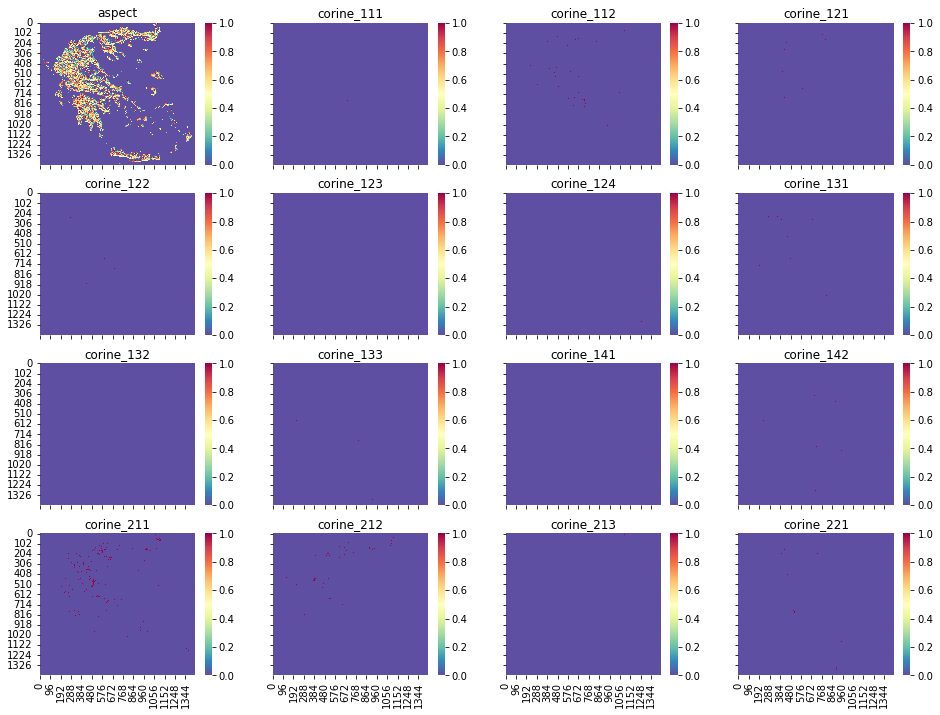

In [38]:
plotfeatures(4, 4, 1, ggrid_patchpool)

Plotting 49th feature : corine_222 at subplot 0,0
Plotting 50th feature : corine_223 at subplot 0,1
Plotting 51st feature : corine_231 at subplot 0,2
Plotting 52nd feature : corine_241 at subplot 0,3
Plotting 53rd feature : corine_242 at subplot 1,0
Plotting 54th feature : corine_243 at subplot 1,1
Plotting 55th feature : corine_244 at subplot 1,2
Plotting 56th feature : corine_311 at subplot 1,3
Plotting 57th feature : corine_312 at subplot 2,0
Plotting 58th feature : corine_313 at subplot 2,1
Plotting 59th feature : corine_321 at subplot 2,2
Plotting 60th feature : corine_322 at subplot 2,3
Plotting 61st feature : corine_323 at subplot 3,0
Plotting 62nd feature : corine_324 at subplot 3,1
Plotting 63rd feature : corine_331 at subplot 3,2
Plotting 64th feature : corine_332 at subplot 3,3


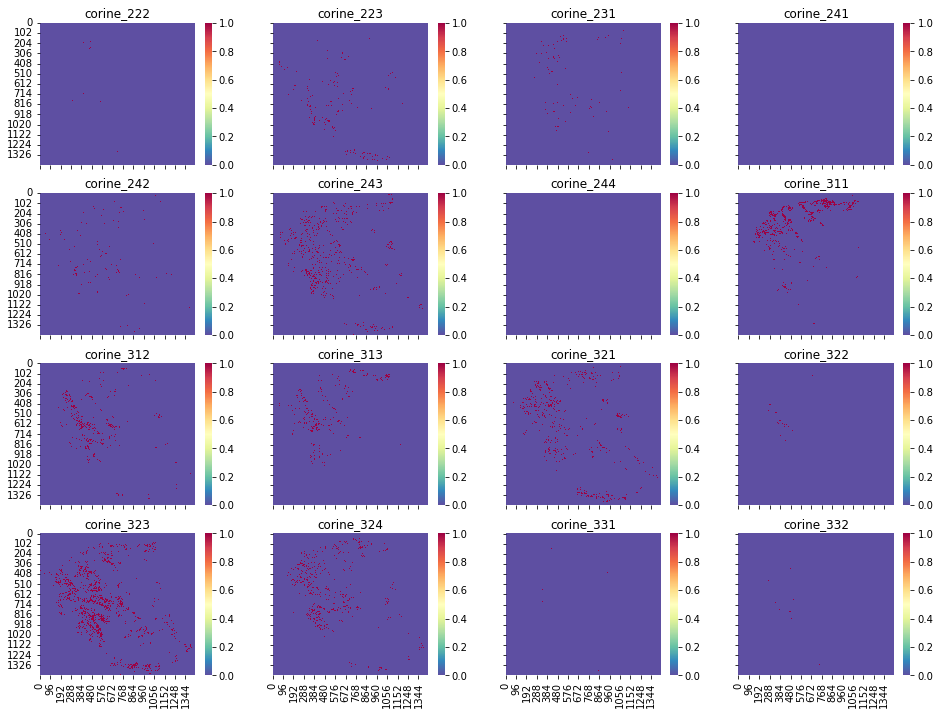

In [39]:
plotfeatures(4, 4, 17, ggrid_patchpool)

Plotting 65th feature : corine_333 at subplot 0,0
Plotting 66th feature : corine_334 at subplot 0,1
Plotting 67th feature : corine_411 at subplot 0,2
Plotting 68th feature : corine_412 at subplot 0,3
Plotting 69th feature : corine_421 at subplot 1,0
Plotting 70th feature : corine_422 at subplot 1,1
Plotting 71st feature : corine_511 at subplot 1,2
Plotting 72nd feature : corine_512 at subplot 1,3
Plotting 73rd feature : corine_521 at subplot 2,0
Plotting 8th feature : curvature at subplot 2,1
Plotting 6th feature : dem at subplot 2,2
Plotting 18th feature : dir_max_1 at subplot 2,3
Plotting 19th feature : dir_max_2 at subplot 3,0
Plotting 20th feature : dir_max_3 at subplot 3,1
Plotting 21st feature : dir_max_4 at subplot 3,2
Plotting 22nd feature : dir_max_5 at subplot 3,3


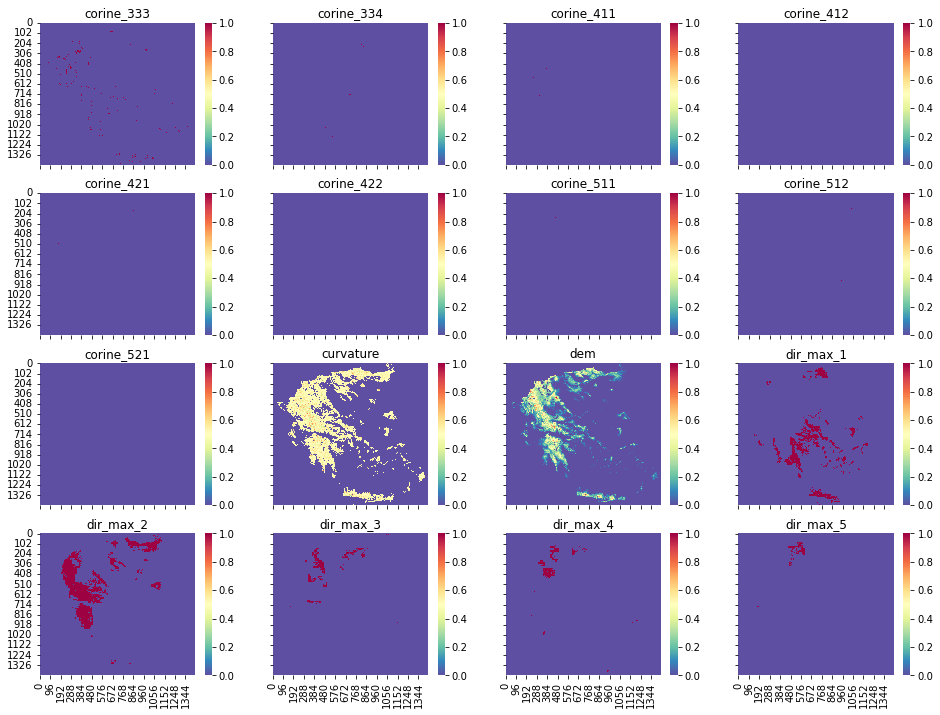

In [40]:
plotfeatures(4, 4, 33, ggrid_patchpool)

Plotting 23rd feature : dir_max_6 at subplot 0,0
Plotting 24th feature : dir_max_7 at subplot 0,1
Plotting 25th feature : dir_max_8 at subplot 0,2
Plotting 26th feature : dom_dir_1 at subplot 0,3
Plotting 27th feature : dom_dir_2 at subplot 1,0
Plotting 28th feature : dom_dir_3 at subplot 1,1
Plotting 29th feature : dom_dir_4 at subplot 1,2
Plotting 30th feature : dom_dir_5 at subplot 1,3
Plotting 31st feature : dom_dir_6 at subplot 2,0
Plotting 32nd feature : dom_dir_7 at subplot 2,1
Plotting 33rd feature : dom_dir_8 at subplot 2,2
Plotting 4th feature : dom_vel at subplot 2,3
Plotting 11th feature : evi at subplot 3,0
Plotting 88th feature : f81 at subplot 3,1
Plotting 17th feature : fire at subplot 3,2
Plotting 87th feature : frequency at subplot 3,3


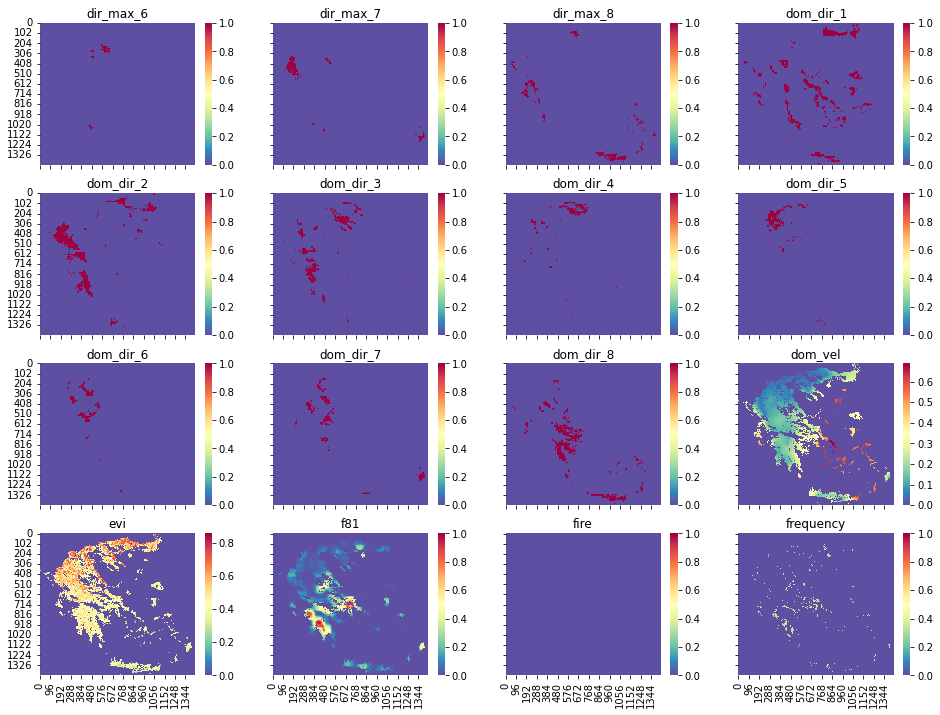

In [41]:
plotfeatures(4, 4, 49, ggrid_patchpool)

Plotting 12th feature : lst_day at subplot 0,0
Plotting 13th feature : lst_night at subplot 0,1
Plotting 14th feature : max_dew_temp at subplot 0,2
Plotting 0th feature : max_temp at subplot 0,3
Plotting 15th feature : mean_dew_temp at subplot 1,0
Plotting 2nd feature : mean_temp at subplot 1,1
Plotting 16th feature : min_dew_temp at subplot 1,2
Plotting 1st feature : min_temp at subplot 1,3
Plotting 82nd feature : month_4 at subplot 2,0
Plotting 83rd feature : month_5 at subplot 2,1
Plotting 84th feature : month_6 at subplot 2,2
Plotting 85th feature : month_7 at subplot 2,3
Plotting 81st feature : month_8 at subplot 3,0
Plotting 86th feature : month_9 at subplot 3,1
Plotting 10th feature : ndvi_new at subplot 3,2
Plotting 5th feature : rain_7days at subplot 3,3


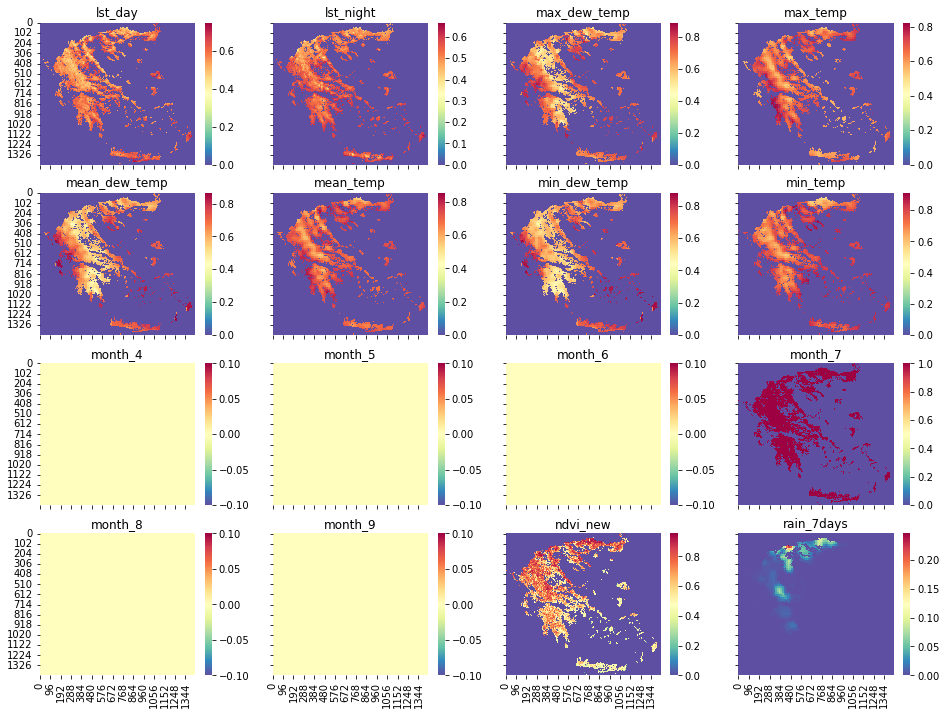

In [42]:
plotfeatures(4, 4, 65, ggrid_patchpool)

In [ ]:
plotfeatures(4, 4, 81, ggrid_patchpool)

Plotting 3rd feature : res_max at subplot 0,0
Plotting 7th feature : slope at subplot 0,1
Plotting 74th feature : wkd_0 at subplot 0,2
Plotting 75th feature : wkd_1 at subplot 0,3
Plotting 76th feature : wkd_2 at subplot 1,0
Plotting 77th feature : wkd_3 at subplot 1,1
Plotting 78th feature : wkd_4 at subplot 1,2
Plotting 79th feature : wkd_5 at subplot 1,3
Plotting 80th feature : wkd_6 at subplot 2,0
Plotting 89th feature : x at subplot 2,1
Plotting 90th feature : y at subplot 2,2


In [ ]:
#fday='/data2/ffp/datasets/daily/2018/08/20180823_norm.csv'
fday='/data2/ffp/datasets/daily/2021/08/20210803_norm.csv'
exfeat = ["id", "firedate"]
ggrid_id, ggrid_patchpool = creategrid(fday, exfeat)

In [ ]:
plotfeatures(1, 2, 4)

In [ ]:
fday='/data2/ffp/datasets/trainingsets/randomnofire/old_random_new_feat_from_months.csv'
exfeat = ["id", "firedate"]
ggrid_id, ggrid_patchpool = creategrid(fday, exfeat)

In [ ]:
plotfeatures(1, 2, 4)

In [ ]:
fday='/data2/ffp/datasets/daily/2019/08/20190813_norm.csv'
exfeat = ["id", "firedate"]
ggrid_id, ggrid_patchpool = creategrid(fday, exfeat)

In [ ]:
plotfeatures(1, 2, 4, ggrid_patchpool)

In [20]:
dic = {'A': [1, 4, 1, 4], 'B': [9, 2, 5, 3], 'C': [0, 0, 5, 3]}
df = pd.DataFrame(dic)

In [21]:
df

,A,B,C
0,1,9,0
1,4,2,0
2,1,5,5
3,4,3,3


In [22]:
df['A'] = df['A']*(1+0.1)

In [23]:
df

,A,B,C
0,1.1,9,0
1,4.4,2,0
2,1.1,5,5
3,4.4,3,3
